# Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
isolasi = pd.read_csv('isolasi.csv')
icu = pd.read_csv('icu.csv')

isolasi.tail()

,Tanggal,Total TT Isolasi,Total Pasien Isolasi,% Keterpakaian TT Isolasi
351,17 Nov 2021,4.283,177.0,4%
352,18 Nov 2021,4.279,198.0,5%
353,19 Nov 2021,4.256,195.0,5%
354,20 Nov 2021,4.256,196.0,5%
355,21 Nov 2021,4.256,185.0,4%


In [ ]:
icu.tail()

,Tanggal,Total TT ICU,Total Pasien ICU,% Keterpakaian TT ICU
351,17 Nov 2021,675.0,47.0,7%
352,18 Nov 2021,675.0,46.0,7%
353,19 Nov 2021,669.0,45.0,7%
354,20 Nov 2021,673.0,44.0,7%
355,21 Nov 2021,675.0,42.0,6%


In [ ]:
print(isolasi.shape)
print(icu.shape)

(356, 4)
(356, 4)


In [ ]:
print(isolasi.isna().sum())
print(icu.isna().sum())

Tanggal                      0
Total TT Isolasi             0
Total Pasien Isolasi         0
% Keterpakaian TT Isolasi    0
dtype: int64
Tanggal                  0
Total TT ICU             0
Total Pasien ICU         0
% Keterpakaian TT ICU    0
dtype: int64


In [ ]:
data = isolasi.merge(icu, on='Tanggal')
data.head()

,Tanggal,Total TT Isolasi,Total Pasien Isolasi,% Keterpakaian TT Isolasi,Total TT ICU,Total Pasien ICU,% Keterpakaian TT ICU
0,1 Des 2020,6.178,4.849,78%,875.0,630.0,72%
1,2 Des 2020,6.181,4.866,79%,881.0,628.0,71%
2,3 Des 2020,6.230,4.908,79%,883.0,628.0,71%
3,4 Des 2020,6.305,4.985,79%,874.0,610.0,70%
4,5 Des 2020,6.302,4.960,79%,874.0,620.0,71%


In [ ]:
# data.['Tanggal'].str.replace()
data['Tanggal'].replace(regex={'Mei': 'May',
                              'Agu': 'Aug',
                              'Okt': 'Oct',
                              'Des': 'Dec'}, inplace=True)

In [ ]:
data['date'] = pd.to_datetime(data['Tanggal'], format='%d %b %Y')
data.set_index('date', inplace=True)
data.drop('Tanggal', axis=1, inplace=True)

In [ ]:
data

,Total TT Isolasi,Total Pasien Isolasi,% Keterpakaian TT Isolasi,Total TT ICU,Total Pasien ICU,% Keterpakaian TT ICU
date,,,,,,
2020-12-01,6.178,4.849,78%,875.0,630.0,72%
2020-12-02,6.181,4.866,79%,881.0,628.0,71%
2020-12-03,6.230,4.908,79%,883.0,628.0,71%
2020-12-04,6.305,4.985,79%,874.0,610.0,70%
2020-12-05,6.302,4.960,79%,874.0,620.0,71%
...,...,...,...,...,...,...
2021-11-17,4.283,177.000,4%,675.0,47.0,7%
2021-11-18,4.279,198.000,5%,675.0,46.0,7%
2021-11-19,4.256,195.000,5%,669.0,45.0,7%


In [ ]:
data.describe()

,Total TT Isolasi,Total Pasien Isolasi,Total TT ICU,Total Pasien ICU
count,356.000000,356.000000,356.000000,356.000000
mean,7.597514,88.522772,233.331742,451.914281
std,1.856738,185.237834,386.122710,307.619131
min,4.256000,1.017000,1.001000,1.019000
25%,6.564000,3.285750,1.105750,166.000000
50%,7.375500,5.738500,1.215000,474.000000
75%,8.288250,10.256250,707.000000,736.000000
max,11.773000,981.000000,996.000000,994.000000


# Modeling

## Identification

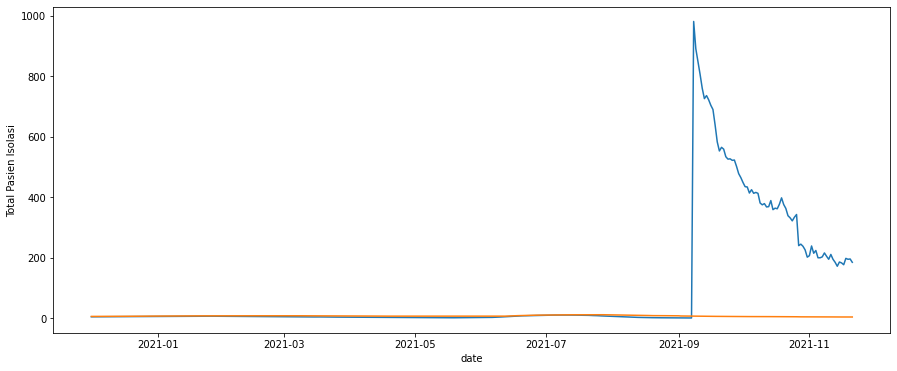

In [ ]:
plt.figure(figsize=(15,6))

sns.lineplot(x=data.index,
            y='Total Pasien Isolasi',
            data=data)

sns.lineplot(x=data.index,
            y='Total TT Isolasi',
            data=data)

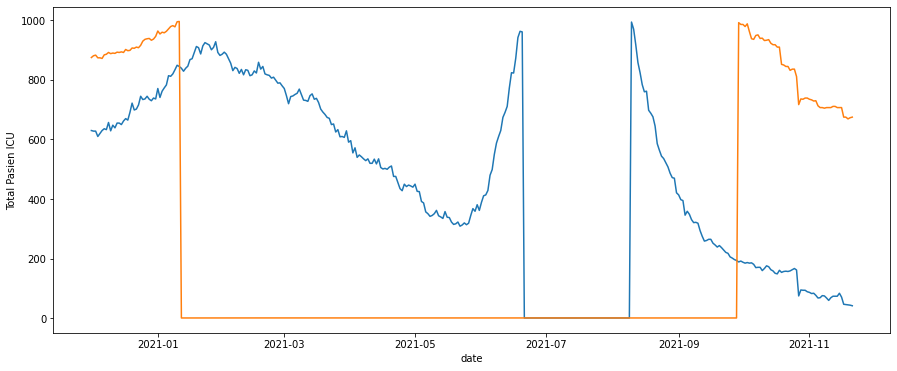

In [ ]:
plt.figure(figsize=(15,6))

sns.lineplot(x=data.index,
            y='Total Pasien ICU',
            data=data)

sns.lineplot(x=data.index,
            y='Total TT ICU',
            data=data)

### Dicky-Fuller Test

Tes yang paling umum untuk mengidentifikasi apakah deret waktu non-stasioner adalah tes Dicky-Fuller.

H0 = Data tidak Stasioner

In [ ]:
df_isolasi = data['Total Pasien Isolasi']
df_icu = data['Total Pasien ICU']

isolasi_dft = adfuller(df_isolasi)
icu_dft = adfuller(df_icu)
# Print test statistic and P-value
print('Isolasi Test Statistics ',isolasi_dft[0])
print('Isolasi p-value ',isolasi_dft[1])

print('ICU Test Statistics ',icu_dft[0])
print('ICU p-value ',icu_dft[1])

Isolasi Test Statistics  -2.7231784681893583
Isolasi p-value  0.07011254311536365
ICU Test Statistics  -2.1651871204750113
ICU p-value  0.2191221893442057


Jika p-value lebih kecil dari 0.05, maka tolak H0.

Sehingga data Total Pasien Isolasi diasumsikan tidak stasioner dan data Total Pasien ICU diasumsikan Stasioner.

Harus dilakukan Differencing pada data Total Pasien Isolasi.

### Differencing

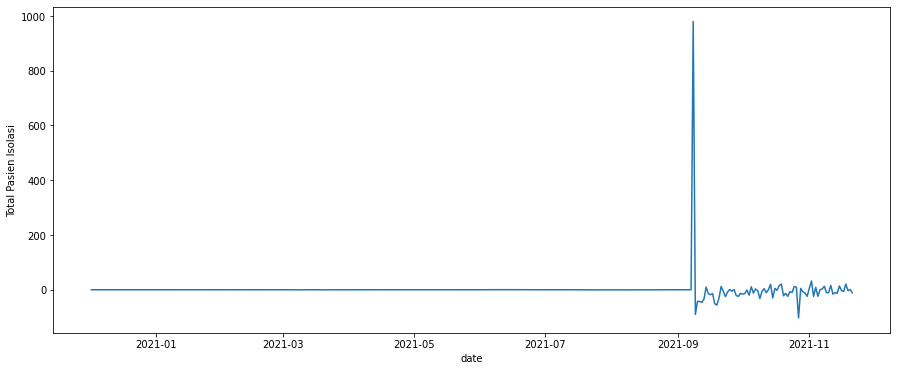

Isolasi Test Statistics  -20.23082359651885
Isolasi p-value  0.0


In [ ]:
isolasi_diff = df_isolasi.diff().dropna()

isolasi_diff_dft = adfuller(isolasi_diff)

plt.figure(figsize=(15,6))
sns.lineplot(x=isolasi_diff.index,
            y=isolasi_diff,
            data=isolasi_diff)
plt.show()

print('Isolasi Test Statistics ',isolasi_diff_dft[0])
print('Isolasi p-value ',isolasi_diff_dft[1])

Setelah dilakukan differencing datanya sudah stasioner dan sudah bisa digunakan untuk modeling.

### Plot ACF dan PACF

#### Plot ACF dan PACF Data Total Pasien Isolasi

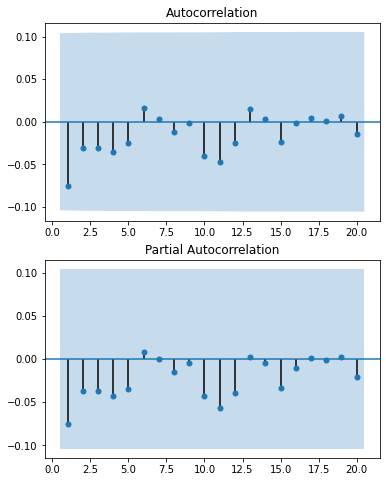

In [ ]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,8))
 
# Plot the ACF of savings on ax1
plot_acf(isolasi_diff, lags=20, zero=False, ax=ax1)
 
# Plot the PACF of savings on ax2
plot_pacf(isolasi_diff, lags=20, zero=False, ax=ax2)
 
plt.show()

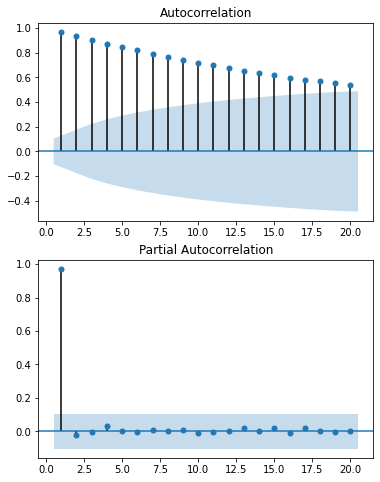

In [ ]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,8))
 
# Plot the ACF of savings on ax1
plot_acf(df_icu, lags=20, zero=False, ax=ax1)
 
# Plot the PACF of savings on ax2
plot_pacf(df_icu, lags=20, zero=False, ax=ax2)
 
plt.show()

## Estimation


### Penentuan Order berdasarkan AIC dan BIC
#### AIC dan BIC pada Data Total Pasien Isolasi

In [ ]:
# Create empty list to store search results
order_aic_bic=[]

# Loop over p values from 0-3
for p in range(3):
  
  # Loop over q values from 0-3
    for q in range(3):
      try:
        # Create and fit ARMA(p,q) model
        model = SARIMAX(df_isolasi, order=(p,1,q), trend='c')
        results = model.fit()
        
        # Print p, q, AIC, BIC
        order_aic_bic.append((p,q,results.aic,results.bic))
        
      except:
        order_aic_bic.append((p,q,None,None))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packa

In [ ]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p', 'q', 'AIC', 'BIC'])
 
# Print order_df in order of increasing AIC
print(order_df.sort_values('AIC'))
 
# Print order_df in order of increasing BIC
print(order_df.sort_values('BIC'))

   p  q          AIC          BIC
4  1  1  3829.313538  3844.802009
5  1  2  3830.446437  3849.807026
7  2  1  3830.468363  3849.828952
8  2  2  3832.446133  3855.678840
1  0  1  3833.436441  3845.052794
3  1  0  3833.596389  3845.212743
0  0  0  3833.608482  3841.352718
2  0  2  3834.918271  3850.406742
6  2  0  3835.122500  3850.610971
   p  q          AIC          BIC
0  0  0  3833.608482  3841.352718
4  1  1  3829.313538  3844.802009
1  0  1  3833.436441  3845.052794
3  1  0  3833.596389  3845.212743
5  1  2  3830.446437  3849.807026
7  2  1  3830.468363  3849.828952
2  0  2  3834.918271  3850.406742
6  2  0  3835.122500  3850.610971
8  2  2  3832.446133  3855.678840


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


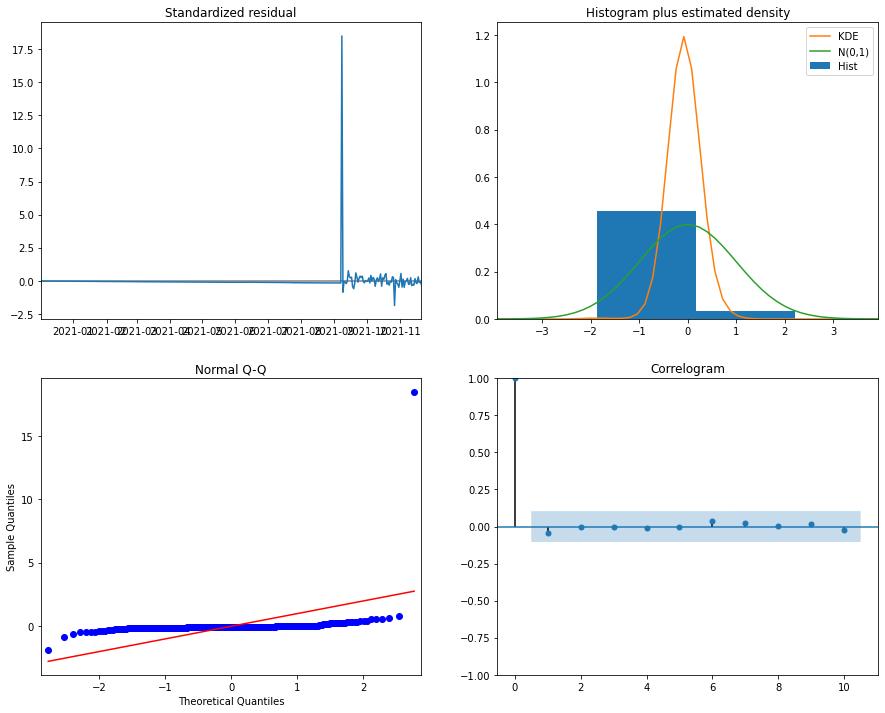

                            Statespace Model Results                            
Dep. Variable:     Total Pasien Isolasi   No. Observations:                  356
Model:                 SARIMAX(1, 1, 1)   Log Likelihood               -1910.657
Date:                  Thu, 02 Dec 2021   AIC                           3829.314
Time:                          06:44:27   BIC                           3844.802
Sample:                      12-01-2020   HQIC                          3835.475
                           - 11-21-2021                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0525      0.171      0.307      0.759      -0.283       0.388
ar.L1          0.9422      0.063     14.861      0.000       0.818       1.067
ma.L1         -1.0000      9.051    

In [ ]:
# Create and fit model
model = SARIMAX(df_isolasi, order=(1,1,1), trend = 'c')
results = model.fit()
 
# Create the 4 diagostics plots
results.plot_diagnostics(figsize=(15, 12))
plt.show()
 
# Print summary
print(results.summary())

In [ ]:
import pickle
# save the model to disk
filename = 'sarimax_model.pkl'
pickle.dump(results, open(filename, 'wb'))

In [ ]:
# test model forecasting

from pandas.tseries.offsets import DateOffset
data = pd.DataFrame(df_isolasi.copy())

pred_date=[data.index[-1]+ DateOffset(days=x)for x in range(0,365)]
pred_date=pd.DataFrame(index=pred_date[1:],columns=data.columns)
print(pred_date)

           Total Pasien Isolasi
2021-11-22                  NaN
2021-11-23                  NaN
2021-11-24                  NaN
2021-11-25                  NaN
2021-11-26                  NaN
...                         ...
2022-11-16                  NaN
2022-11-17                  NaN
2022-11-18                  NaN
2022-11-19                  NaN
2022-11-20                  NaN

[364 rows x 1 columns]


In [ ]:
data_merge=pd.concat([data,pred_date])
data_merge.to_csv('data_merge.csv')

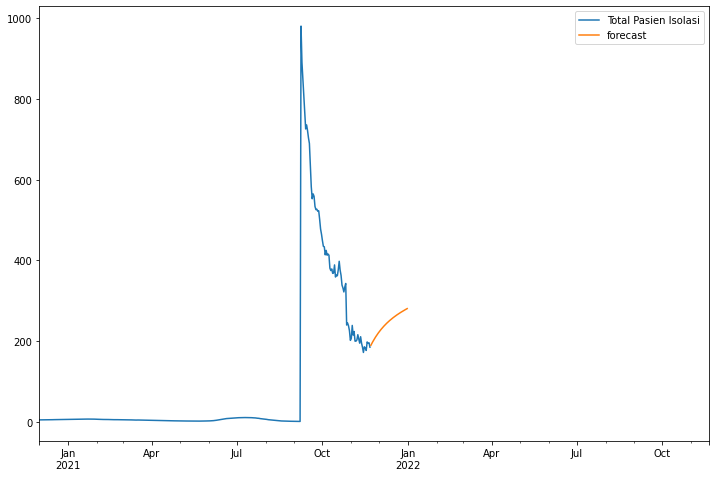

In [ ]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

data_merge['forecast'] = loaded_model.predict(start = 356, end = 356+39, dynamic= True)
data_merge[['Total Pasien Isolasi', 'forecast']].plot(figsize=(12, 8))

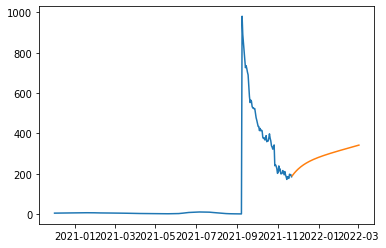

In [ ]:
fig, ax = plt.subplots()
ax.plot(data_merge[['Total Pasien Isolasi', 'forecast']])